In [121]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import sqlite3
import numpy as np

In [16]:
# 解决中文乱码问题
mpl.rcParams['font.sans-serif']=['SimSun']
mpl.rcParams['axes.unicode_minus']=False

In [2]:
# 连接数据集
conn = sqlite3.connect('dinofunworld.db')

游乐园管理部门提供的数据库格式化可供任何 SQL 数据库读取。课程员工推荐 使用sqlite3 库。该数据库包含三个表格，分别为“登记”、“景点”和“序列”。每个表中所含的信息如下所示： 

登记：

- 说明：游乐园当天所有游客的登记数据。该数据包括两类登记数据，即推测登记数据和实际登记数据。

- 字段：游客编号 (visitorID)、时间戳 (timestamp)、景点 (attraction)、持续时间 (duration)、类型 (type)

 

景点:

- 游乐园景点包括相应的景点编号、名称、区域、类别和类型。区域包括 VAST 挑战地图，如过山车场区、冻原之地等。类别包括惊险飞车、儿童碰碰车等。类型包括户外过山车、其他游乐项目、旋转木马等

- 字段：景点编号 (AttractionID)、名称 (Name)、区域 (Region)、类别 (Category), 类型 (type)

序列：

- 游客登记序列。这些序列列出每五分钟进入游乐场的每个游客位置。如果游客尚未进入游乐场，则该时间段内序列的值为 0。如果游客已进入游乐场，则序列列出游客最近登记的景点，或游客离开游乐场前最后登记的景点。

- 字段：游客编号 (visitorID)、序列 (sequence)

数据库文件名称为“dinofunworld.db”，可以在 Jupyter Notebook 环境（即 readonly/dinofunworld.db）中的只读目录中找到。

### 图表1

- 描述游览惊险飞车（thrill ride）景点的饼图

In [6]:
# plt.pie()
# 从attraction查询thrill ride分类下的景点名称，连接checkin表中去重的visitorID的计数，连接checkin中duration的累计和
thrill_ride_data = """
                    SELECT
                        a1.Name,
                        a1.visitors,
                        a2.visitor_time 
                    FROM
                        (
                        SELECT
                            attraction,
                            Name,
                            count( DISTINCT visitorID ) AS visitors 
                        FROM
                            checkin,
                            attraction 
                        WHERE
                            checkin.attraction = attraction.AttractionID 
                            AND attraction.Category LIKE '%Thrill Rides%' 
                        GROUP BY
                            attraction 
                        ORDER BY
                            visitors DESC 
                        ) a1
                        LEFT JOIN (
                        SELECT
                            attraction,
                            sum(
                            CASE

                                    WHEN duration IS NULL THEN
                                    0 
                                    WHEN duration LIKE '%@SD%' THEN
                                    CAST ( duration AS int ) * 3600 + SUBSTR( duration,- 8, 2 ) * 60 + SUBSTR( duration,- 5, 2 ) ELSE CAST ( duration AS int ) * 3600 + SUBSTR( duration,- 5, 2 ) * 60 + SUBSTR( duration,- 2, 2 ) 
                                END 
                                ) AS visitor_time 
                            FROM
                                checkin 
                            GROUP BY
                            attraction 
                        ) a2 ON a1.attraction = a2.attraction;"""
tr_frame = pd.read_sql(thrill_ride_data,con=conn)
tr_frame

,Name,visitors,visitor_time
0,Atmosfear,9421,18757003
1,Keimosaurus Big Spin,8039,7249906
2,Auvilotops Express,8012,16012645
3,Galactosaurus Rage,7883,5396495
4,Wrightiraptor Mountain,7831,5039210
5,Wendisaurus Chase,7488,37309665
6,Flight of the Swingodon,7363,41109036
7,Firefall,7284,37556043
8,TerrorSaur,7061,40350332


In [23]:
# 计算各thrill rides景点游客数在所有thrill rides总游客数的占比
tr_frame['visitors_percent'] = pd.DataFrame(tr_frame['visitors']/tr_frame['visitors'].sum())

,Name,visitors,visitor_time,visitors_percent
0,Atmosfear,9421,18757003,0.133855
1,Keimosaurus Big Spin,8039,7249906,0.114220
2,Auvilotops Express,8012,16012645,0.113836
3,Galactosaurus Rage,7883,5396495,0.112003
4,Wrightiraptor Mountain,7831,5039210,0.111264
5,Wendisaurus Chase,7488,37309665,0.106391
6,Flight of the Swingodon,7363,41109036,0.104615
7,Firefall,7284,37556043,0.103492
8,TerrorSaur,7061,40350332,0.100324


In [24]:
# 计算各thrill rides景点游客人均时长在所有thrill rides总人均时长的占比
tr_frame['time_percent'] = pd.DataFrame(tr_frame['visitor_time']/tr_frame['visitor_time'].sum())

In [25]:
tr_frame

,Name,visitors,visitor_time,visitors_percent,time_percent
0,Atmosfear,9421,18757003,0.133855,0.089841
1,Keimosaurus Big Spin,8039,7249906,0.114220,0.034725
2,Auvilotops Express,8012,16012645,0.113836,0.076696
3,Galactosaurus Rage,7883,5396495,0.112003,0.025848
4,Wrightiraptor Mountain,7831,5039210,0.111264,0.024136
5,Wendisaurus Chase,7488,37309665,0.106391,0.178703
6,Flight of the Swingodon,7363,41109036,0.104615,0.196901
7,Firefall,7284,37556043,0.103492,0.179883
8,TerrorSaur,7061,40350332,0.100324,0.193267


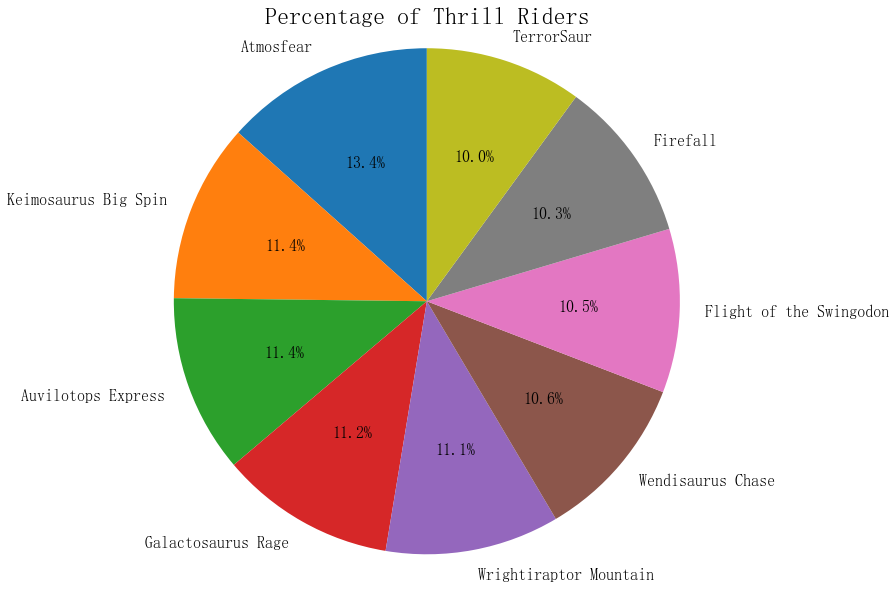

In [35]:
plt.figure(figsize=(10,10))
plt.pie(tr_frame['visitors_percent'],
        labels=tr_frame['Name'],
        autopct="%3.1f%%", # 设置标签百分比
        shadow=False,
        textprops={'fontsize':16}, # 设置标签字体大小
        startangle=90) # 设置图形起始角度
plt.axis('equal')
plt.title('Percentage of Thrill Riders',fontsize=24)
plt.show()

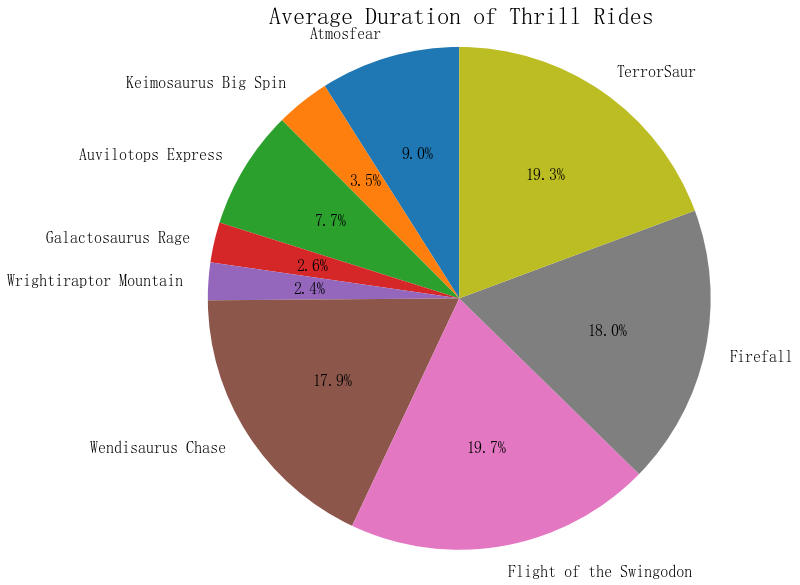

In [36]:
plt.figure(figsize=(10,10))
plt.pie(tr_frame['time_percent'],
        labels=tr_frame['Name'],
        autopct="%3.1f%%",
        shadow=False,
       textprops={'fontsize':16},
       startangle=90)
plt.axis('equal')
plt.title('Average Duration of Thrill Rides',fontsize=24)
plt.show()

### 图表2

- 描述美食摊位（food stall）总访问量的柱状图

In [32]:
# plt.bar()
food_data = """
            SELECT
                a.Name,
                b.consumers 
            FROM
                ( SELECT Name, AttractionID, Category FROM attraction WHERE Category LIKE '%Food%' ) a
                LEFT JOIN ( SELECT attraction, count( DISTINCT visitorID ) AS consumers FROM checkin GROUP BY attraction ) b ON a.AttractionID = b.attraction 
            ORDER BY
                b.consumers DESC;"""
food_frame = pd.read_sql(food_data,con=conn)
food_frame

,Name,consumers
0,Ice Age Cones,2709
1,Floral Funnels,2637
2,Chensational Sweets,2608
3,EberTrex Fries,2589
4,Permafrosties,2547
5,Smoky Wood BBQ,2538
6,Plaisantly Popped Corn,2475
7,Granite Slab Pizza,2381
8,Krystal Cook Cafe,1601
9,Paleo Shreckwiches,1325


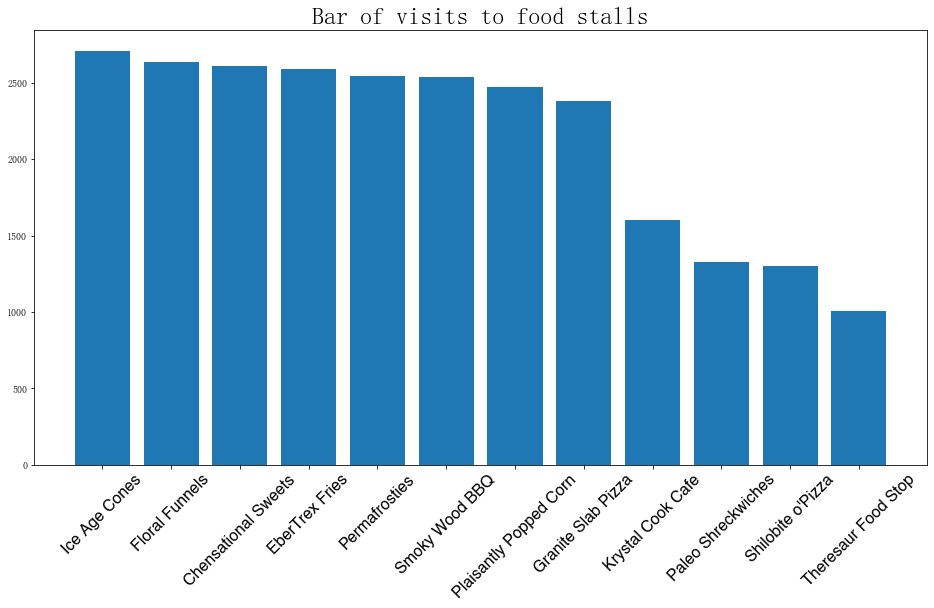

In [46]:
plt.figure(figsize=(16,8))
plt.bar(food_frame['Name'],food_frame['consumers'])
plt.title('Bar of visits to food stalls',fontsize=24)
plt.xticks(fontname="Helvetica",fontsize=16,rotation=45)
plt.show()

### 图表3

- 描述一天之中参加最新游乐项目Atmosfear的折线图

In [67]:
# plt.plot()
time_series = """
           SELECT
                timestamp,
                count( timestamp ) 
            FROM
                (
                SELECT
                    b.Name,
                    a.timestamp 
                FROM
                    ( SELECT timestamp, attraction FROM checkin ) a
                    LEFT JOIN ( SELECT Name, AttractionID FROM attraction WHERE Name LIKE '%Atmosfear%' ) b 
                WHERE
                    b.AttractionID = a.attraction 
                ORDER BY
                    a.timestamp ASC 
                ) 
            GROUP BY
                timestamp;"""
time_frame = pd.read_sql(time_series,con=conn)
time_frame

,timestamp,count( timestamp )
0,2014-06-06 08:11:47,1
1,2014-06-06 08:11:48,3
2,2014-06-06 08:13:31,1
3,2014-06-06 08:13:32,1
4,2014-06-06 08:14:45,1
...,...,...
14150,2014-06-08 22:31:12,1
14151,2014-06-08 22:31:13,1
14152,2014-06-08 22:37:17,23
14153,2014-06-08 22:37:18,6


In [73]:
# 时间序列转换为frame的索引
time_frame.index = pd.to_datetime(time_frame['timestamp'])
time_frame

,timestamp,count( timestamp )
timestamp,,
2014-06-06 08:11:47,2014-06-06 08:11:47,1
2014-06-06 08:11:48,2014-06-06 08:11:48,3
2014-06-06 08:13:31,2014-06-06 08:13:31,1
2014-06-06 08:13:32,2014-06-06 08:13:32,1
2014-06-06 08:14:45,2014-06-06 08:14:45,1
...,...,...
2014-06-08 22:31:12,2014-06-08 22:31:12,1
2014-06-08 22:31:13,2014-06-08 22:31:13,1
2014-06-08 22:37:17,2014-06-08 22:37:17,23


In [74]:
# 删除原先timestamp的列
time_data = time_frame['count( timestamp )']
time_data.index

DatetimeIndex(['2014-06-06 08:11:47', '2014-06-06 08:11:48',
               '2014-06-06 08:13:31', '2014-06-06 08:13:32',
               '2014-06-06 08:14:45', '2014-06-06 08:14:46',
               '2014-06-06 08:15:23', '2014-06-06 08:15:24',
               '2014-06-06 08:16:19', '2014-06-06 08:17:23',
               ...
               '2014-06-08 22:24:04', '2014-06-08 22:27:14',
               '2014-06-08 22:27:15', '2014-06-08 22:30:51',
               '2014-06-08 22:30:52', '2014-06-08 22:31:12',
               '2014-06-08 22:31:13', '2014-06-08 22:37:17',
               '2014-06-08 22:37:18', '2014-06-08 22:37:19'],
              dtype='datetime64[ns]', name='timestamp', length=14155, freq=None)

In [102]:
time_data

timestamp
2014-06-06 08:11:47     1
2014-06-06 08:11:48     3
2014-06-06 08:13:31     1
2014-06-06 08:13:32     1
2014-06-06 08:14:45     1
                       ..
2014-06-08 22:31:12     1
2014-06-08 22:31:13     1
2014-06-08 22:37:17    23
2014-06-08 22:37:18     6
2014-06-08 22:37:19     5
Name: count( timestamp ), Length: 14155, dtype: int64

In [77]:
# 分组求和，求出每五分钟的人数情况
data = time_data.resample('5Min').sum()
data

timestamp
2014-06-06 08:10:00     9
2014-06-06 08:15:00    16
2014-06-06 08:20:00    47
2014-06-06 08:25:00    20
2014-06-06 08:30:00    21
                       ..
2014-06-08 22:15:00    10
2014-06-08 22:20:00    10
2014-06-08 22:25:00     2
2014-06-08 22:30:00     5
2014-06-08 22:35:00    34
Freq: 5T, Name: count( timestamp ), Length: 750, dtype: int64

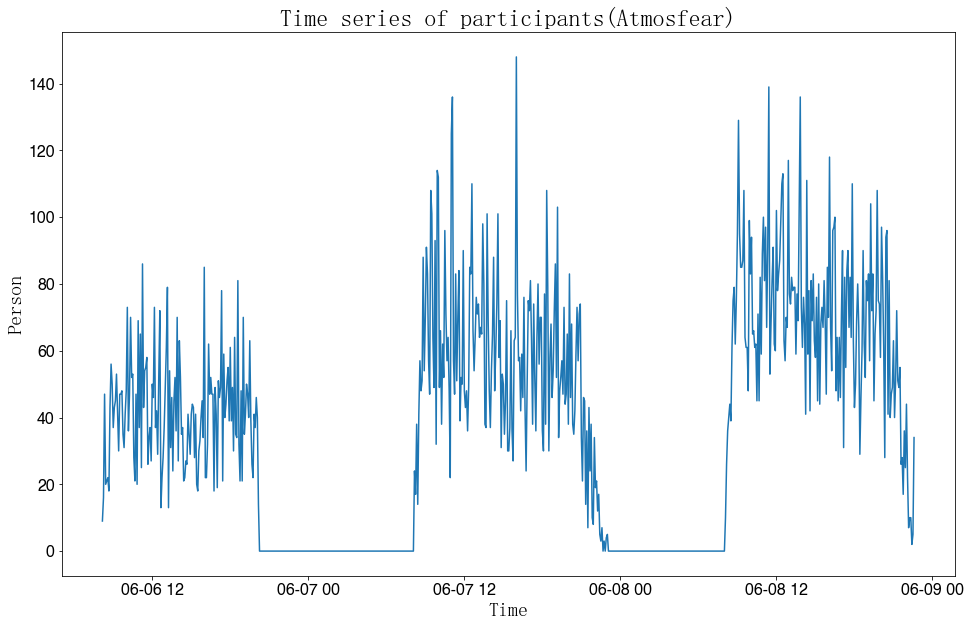

In [95]:
plt.figure(figsize=(16,10))
plt.plot(data)
plt.title('Time series of participants(Atmosfear)',fontsize=24)
plt.xticks(fontname="Helvetica",fontsize=16)
plt.yticks(fontname="Helvetica",fontsize=16)
plt.xlabel('Time',fontsize=20)
plt.ylabel('Person',fontsize=20)
plt.show()

In [ ]:
# 按天查询


### 图表4

- 描绘游乐场的儿童碰碰车（Kiddle Rides）总游览量的箱线图

In [103]:
# plt.boxplot()
kiddie_rides_sql = """
                    SELECT
                        a.Name,
                        b.consumers 
                    FROM
                        ( SELECT Name, AttractionID FROM attraction WHERE Category LIKE '%Kiddie Rides%' ) a
                        LEFT JOIN ( SELECT attraction, count( DISTINCT visitorID ) AS consumers FROM checkin GROUP BY attraction ) b 
                        ON a.AttractionID = b.attraction;"""
kr_frame = pd.read_sql(kiddie_rides_sql,con=conn)
kr_frame

,Name,consumers
0,North Line,2863
1,Jeredactyl Jump,2813
2,Sauroma Bumpers,3099
3,Flying TyrAndrienkos,2768
4,Cyndisaurus Asteroid,2995
5,Beelzebufo,3082
6,Enchanted Toadstools,2912
7,Stegocycles,3064
8,Blue Iguanodon,2866
9,Wild Jungle Cruise,3116


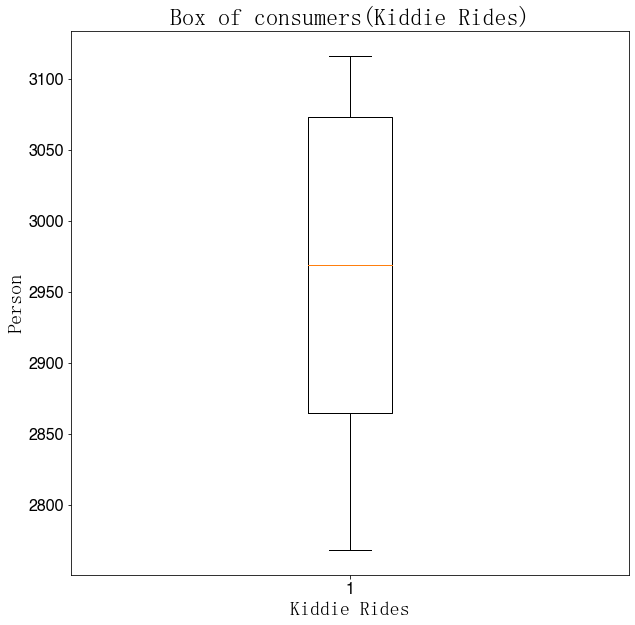

In [108]:
plt.figure(figsize=(10,10))
plt.boxplot(kr_frame['consumers'])
plt.title('Box of consumers(Kiddie Rides)',fontsize=24)
plt.xticks(fontname="Helvetica",fontsize=16)
plt.yticks(fontname="Helvetica",fontsize=16)
plt.xlabel('Kiddie Rides',fontsize=20)
plt.ylabel('Person',fontsize=20)
plt.show()

In [109]:
# 分三日查询
each_day_sql = """
            SELECT
                Name,
                con_day_1st,
                con_day_2nd,
                con_day_3rd 
            FROM
                (
                SELECT
                    * 
                FROM
                    (
                    SELECT
                        * 
                    FROM
                        ( SELECT Name, AttractionID FROM attraction WHERE Category LIKE '%Kiddie Rides%' ) tab
                        LEFT JOIN ( SELECT attraction, count( DISTINCT visitorID ) AS con_day_1st, timestamp FROM checkin WHERE timestamp LIKE '%2014-06-06%' GROUP BY attraction ) day_1st ON tab.AttractionID = day_1st.attraction 
                    ) day_one
                    LEFT JOIN ( SELECT attraction, count( DISTINCT visitorID ) AS con_day_2nd, timestamp FROM checkin WHERE timestamp LIKE '%2014-06-07%' GROUP BY attraction ) day_2nd ON day_one.attraction = day_2nd.attraction 
                ) day_two
                LEFT JOIN ( SELECT attraction, count( DISTINCT visitorID ) AS con_day_3rd, timestamp FROM checkin WHERE timestamp LIKE '%2014-06-08%' GROUP BY attraction ) day_3rd ON day_two.attraction = day_3rd.attraction;
                """
tr_each_day_frame = pd.read_sql(each_day_sql,con=conn)
tr_each_day_frame

,Name,con_day_1st,con_day_2nd,con_day_3rd
0,North Line,709,1037,1405
1,Jeredactyl Jump,697,1101,1351
2,Sauroma Bumpers,680,1222,1522
3,Flying TyrAndrienkos,703,1162,1231
4,Cyndisaurus Asteroid,727,1038,1518
5,Beelzebufo,743,1203,1435
6,Enchanted Toadstools,677,1170,1342
7,Stegocycles,812,1162,1411
8,Blue Iguanodon,703,1106,1380
9,Wild Jungle Cruise,793,1271,1435


In [147]:
all_day_data = tr_each_day_frame[['con_day_1st','con_day_2nd','con_day_3rd']].values
all_day_data

array([[ 709, 1037, 1405],
       [ 697, 1101, 1351],
       [ 680, 1222, 1522],
       [ 703, 1162, 1231],
       [ 727, 1038, 1518],
       [ 743, 1203, 1435],
       [ 677, 1170, 1342],
       [ 812, 1162, 1411],
       [ 703, 1106, 1380],
       [ 793, 1271, 1435],
       [ 706, 1136, 1469]])

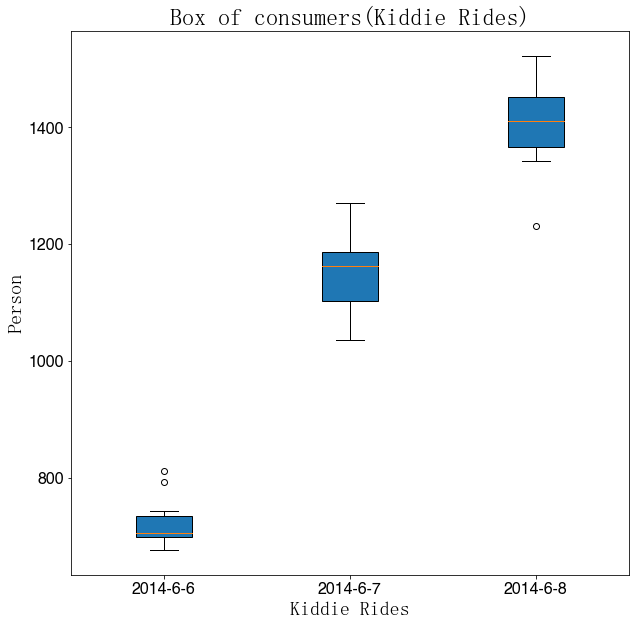

In [151]:
labels = ['2014-6-6','2014-6-7','2014-6-8']

plt.figure(figsize=(10,10))
plt.boxplot(all_day_data,
            vert=True,  # vertical box alignment
            patch_artist=True,  # fill with color
            labels=labels)
plt.title('Box of consumers(Kiddie Rides)',fontsize=24)
plt.xticks(fontname="Helvetica",fontsize=16)
plt.yticks(fontname="Helvetica",fontsize=16)
plt.xlabel('Kiddie Rides',fontsize=20)
plt.ylabel('Person',fontsize=20)
plt.show()